# Exercises

**Exercise:** Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone’s weight, how much would it help to know their height?

Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is totalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. How much does correct weighting affect the estimates?

#### compute the linear least squares fit for log(weight) versus height.

In [2]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np

import random

import thinkstats2
import thinkplot



In [14]:
import brfss

df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

In [4]:

#The following function computes the intercept and slope of the least squares fit.

from thinkstats2 import Mean, MeanVar, Var, Std, Cov

def LeastSquares(xs, ys):
    meanx, varx = MeanVar(xs)
    meany = Mean(ys)

    slope = Cov(xs, ys, meanx, meany) / varx
    inter = meany - slope * meanx

    return inter, slope

#### Estimate intercept and slope.


In [33]:
# Here's the least squares fit to heights as a function of log_weights. 

inter, slope = LeastSquares(heights, log_weights)
inter, slope

(0.993080416391812, 0.005281454169417809)

#### Make a scatter plot of the data and show the fitted line.

In [34]:
# The following function evaluates the fitted line at the given xs (log_weights).

def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys

In [35]:
# runing the function 
fit_xs, fit_ys = FitLine(heights, inter, slope)

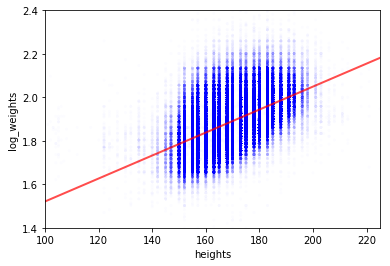

In [38]:
# Here's a scatterplot of the data with the fitted line.
thinkplot.Scatter(heights, log_weights,  color='blue', alpha=0.01, s=10)
#thinkplot.Plot(fit_xs, fit_ys, color='white', linewidth=3)
thinkplot.Plot(fit_xs, fit_ys, color='red', linewidth=2)
thinkplot.Config(xlabel="heights",
                 ylabel='log_weights',
                 axis=[ 100, 225, 1.4, 2.4],
                 legend=False)

#### Make the same plot but apply the inverse transform to show weights on a linear (not log) scale.

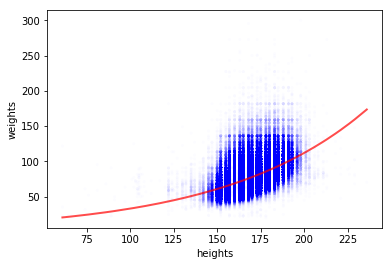

In [40]:
thinkplot.Scatter(heights, weights,  color='blue', alpha=0.01, s=10)
#thinkplot.Plot(fit_xs, fit_ys, color='white', linewidth=3)
thinkplot.Plot(fit_xs, 10**fit_ys, color='red', linewidth=2)
thinkplot.Config(xlabel="heights",
                 ylabel='weights',
                 #axis=[ 100, 225, 1.4, 2.4],
                 legend=False)

#### Plot percentiles of the residuals.

In [41]:
# The following functon computes the residuals.
def Residuals(xs, ys, inter, slope):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    res = ys - (inter + slope * xs)
    return res

In [43]:
# Now we can add the residuals as a column in the DataFrame
df['residual'] = Residuals(heights, log_weights, inter, slope)

To visualize the residuals, I'll split the respondents into groups by heights, then plot the percentiles of the residuals versus the average heights in each group.
First I'll make the groups and compute the average heights in each group.


In [49]:
bins = np.arange(130, 210, 5)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

heights_means = [group.htm3.mean() for _, group in groups][1:-1]
heights_means

[130.8842105263158,
 135.78508771929825,
 141.43396226415095,
 146.33718778908417,
 151.52843968228584,
 156.3503419942746,
 161.67421045177736,
 166.56972746679975,
 171.40954232482787,
 176.54908086026674,
 181.57596142807944,
 186.32469990536435,
 191.7859712230216,
 196.6426561620709,
 201.73827160493826]

In [50]:
# Next I'll compute the CDF of the residuals in each group.
cdfs = [thinkstats2.Cdf(group.residual) for _, group in groups][1:-1]

In [51]:
# The following function plots percentiles of the residuals against the average age in each group.
def PlotPercentiles(age_means, cdfs):
    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(age_means, weight_percentiles, label=label)

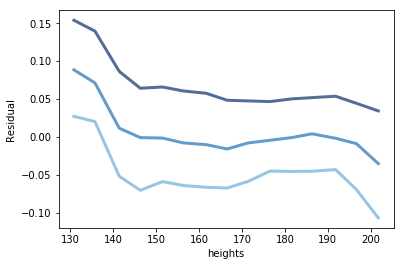

In [54]:
#The following figure shows the 25th, 50th, and 75th percentiles.
#Curvature in the residuals suggests a non-linear relationship.


PlotPercentiles(heights_means, cdfs)

thinkplot.Config(xlabel="heights",
                 ylabel='Residual ',)

#### Compute correlation.

In [57]:
print('corretaltion: ', thinkstats2.Corr(heights, log_weights))

corretaltion:  0.5317282605983434


#### Compute coefficient of determination

In [58]:
# The coefficient compares the variance of the residuals to the variance of the dependent variable.
def CoefDetermination(ys, res):
    return 1 - Var(res) / Var(ys)

In [63]:
r2 = thinkstats2.CoefDetermination(log_weights, df.residual)
print('coefficient of determination:', r2)

coefficient of determination: 0.28273494311894065


We can confirm that $R^2 = \rho^2$:

In [66]:
print('corretaltion:', thinkstats2.Corr(heights, log_weights))
print('R:', np.sqrt(r2))  


corretaltion: 0.5317282605983434
R: 0.5317282605983442


#### Compute Std(ys), which is the RMSE of predictions that don't use height.

In [68]:
std_ys = thinkstats2.Std(log_weights)
print('standard deviation of log_weights', std_ys)

standard deviation of log_weights 0.103207250300049


#### Compute Std(res), the RMSE of predictions that do use height.

In [70]:
std_res = thinkstats2.Std(df.residual)
print('standard deviation of residuals', std_res)

standard deviation of residuals 0.0874077708041609


##### How much does height information reduce RMSE?

In [73]:
print('height information reduce RMSE by', 1 - std_res / std_ys)

height information reduce RMSE by 0.15308497658793452


##### Use resampling to compute sampling distributions for inter and slope.

In [75]:
# To estimate the sampling distribution of inter and slope, I'll use resampling
def SampleRows(df, nrows, replace=False):
    """Choose a sample of rows from a DataFrame.

    df: DataFrame
    nrows: number of rows
    replace: whether to sample with replacement

    returns: DataDf
    """
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

def ResampleRows(df):
    """Resamples rows from a DataFrame.

    df: DataFrame

    returns: DataFrame
    """
    return SampleRows(df, len(df), replace=True)

In [76]:
t = []
for _ in range(100):
    sample = ResampleRows(df)
    estimates = LeastSquares(sample.htm3, np.log10(sample.wtkg2))
    t.append(estimates)

inters, slopes = zip(*t)

#### Plot the sampling distribution of slope.

{'xscale': 'linear', 'yscale': 'linear'}

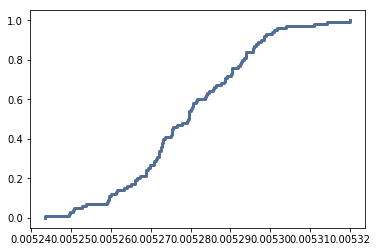

In [77]:
cdf = thinkstats2.Cdf(slopes)
thinkplot.Cdf(cdf)

#### Compute the p-value of the slope.

In [78]:
pvalue = cdf[0]
print('p-value of the slope', pvalue)

p-value of the slope 0


#### Compute the 90% confidence interval of slope.

In [79]:
ci = cdf.Percentile(5), cdf.Percentile(95)
print('the 90% confidence interval of slope is ', ci)

the 90% confidence interval of slope is  (0.005250777183145562, 0.00530102538589564)


#### Compute the mean of the sampling distribution

In [88]:
mean = Mean(slopes)
print('mean of the sampling distribution',mean)

mean of the sampling distribution 0.005279173610552662


#### Compute the standard deviation of the sampling distribution, which is the standard error.

In [89]:
stder = Std(slopes)
print('standard deviation of the sampling distribution', stder)

standard deviation of the sampling distribution 1.5107450270828233e-05


In [90]:
#The following function takes a list of estimates and prints the mean, standard error, and 90% confidence interval.
def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)

#### Resample rows without weights, compute mean height, and summarize results.

In [91]:
#The following function resamples rows with probabilities proportional to weights 
def ResampleRowsWeighted(df, column='finalwgt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

In [93]:
estimates_unweighted = [ResampleRowsWeighted(df, 'finalwt').htm3.mean() for _ in range(100)]
Summarize(estimates_unweighted)

mean, SE, CI 170.4978955465955 0.013969622628794488 (170.47537086440713, 170.5166888983205)
